# DATABASE

## Fuente de la base datos
La base de datos empleada corresponde al proyecto BIG-P3 BCI Dataset, disponible en la plataforma PhysioNet. Puede accederse directamente a través del siguiente enlace:

https://physionet.org/content/bigp3bci/1.0.0/#files-panel

Instala MNE-Python (para análisis de EEG) y pyedflib (para leer archivos .edf). El EDF (European Data Format) es un formato estándar para el almacenamiento de datos de EEG.

In [8]:
pip install mne pyedflib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import mne

file = "J_01_SE001_RC_Test01.edf"   # <-- Colocar el nombre del archivo EDF aquí
raw = mne.io.read_raw_edf(file, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria

print(raw) # Información general sobre los datos cargados
print(raw.info["ch_names"]) #Muesta la lista completa de nombres de canales

# Seleccionar solo canales que empiezan con "EEG_"
eeg_chs = [ch for ch in raw.ch_names if ch.startswith("EEG_")]

raw_eeg = raw.copy().pick(eeg_chs)

raw_eeg.plot(
    n_channels=len(raw_eeg.ch_names),
    duration=10,
    scalings=dict(eeg=20e-6)
)

FileNotFoundError: File does not exist: "c:\Users\franc\Franco\2025-2\INTRO A SEÑALES BIOMEDICAS\PROYECTO\GRUPO-08-ISB-2025-II\Proyecto\Software\J_01_SE001_RC_Test01.edf"

### Vindo eventos

In [ ]:
import numpy as np
import mne

# --- 1. Extraer StimulusCode ---
stim = raw.copy().pick(["StimulusCode"])[0][0][0]

# --- 2. Detectar eventos REALMENTE ---
# Tomamos solo las transiciones donde StimulusCode pasa de 0 -> valor
events = []
for i in range(1, len(stim)):
    if stim[i] != 0 and stim[i-1] == 0:
        events.append([i, 0, int(stim[i])])

events = np.array(events, dtype=int)

print("Eventos detectados:", events[:20])

# --- 3. Definir event_id ---
# Filas 1–6, Columnas 7–12
event_id = {
    "row_1": 1,
    "row_2": 2,
    "row_3": 3,
    "row_4": 4,
    "row_5": 5,
    "row_6": 6,
    "col_1": 7,
    "col_2": 8,
    "col_3": 9,
    "col_4": 10,
    "col_5": 11,
    "col_6": 12,
}

# --- 4. Crear epochs ---
tmin = -0.1
tmax = 0.8

epochs = mne.Epochs(
    raw_eeg,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    baseline=(None, 0),
    preload=True
)

print(epochs)


Eventos detectados: [[1152    0   11]
 [1184    0    4]
 [1216    0    6]
 [1248    0    3]
 [1280    0   12]
 [1312    0    2]
 [1344    0    9]
 [1376    0    1]
 [1408    0    7]
 [1440    0    8]
 [1472    0   10]
 [1504    0    5]
 [1536    0    2]
 [1568    0    8]
 [1600    0    9]
 [1632    0   12]
 [1664    0    4]
 [2592    0   10]
 [2624    0    1]
 [2656    0    3]]
Not setting metadata
109 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 109 events and 232 original time points ...


0 bad epochs dropped
<Epochs | 109 events (all good), -0.102 – 0.801 s (baseline -0.102 – 0 s), ~3.1 MiB, data loaded,
 'row_1': 9
 'row_2': 9
 'row_3': 8
 'row_4': 10
 'row_5': 9
 'row_6': 8
 'col_1': 9
 'col_2': 10
 'col_3': 9
 'col_4': 8
 and 2 more events ...>


#### Viendo respuesta para filas vs columnas

In [ ]:
### Version 1 de colores 
# Filas: tonos de azul 🔵
# Columnas: tonos de rojo 🔴

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18088\4250924461.py:14: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks="EEG_Cz", colors=colors)


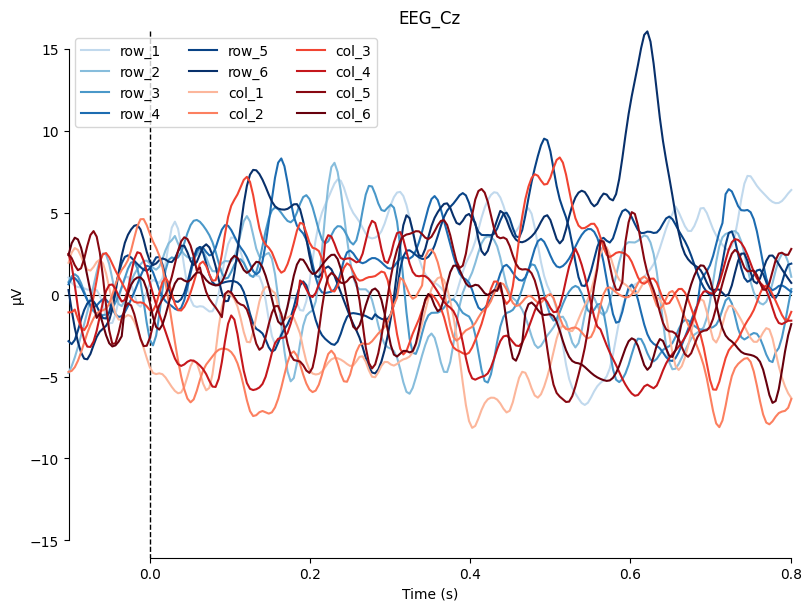

[<Figure size 800x600 with 1 Axes>]

In [ ]:
import matplotlib.pyplot as plt

rows = [c for c in evokeds.keys() if "row" in c]
cols = [c for c in evokeds.keys() if "col" in c]

colors = {}

for i, r in enumerate(rows):
    colors[r] = plt.cm.Blues((i+1)/len(rows)+0.1)

for i, c in enumerate(cols):
    colors[c] = plt.cm.Reds((i+1)/len(cols)+0.1)

mne.viz.plot_compare_evokeds(evokeds, picks="EEG_Cz", colors=colors)


In [ ]:
### Version 2 de colores 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18088\1365671945.py:12: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds( evokeds, picks="EEG_Cz", colors=colors, legend='upper right' )


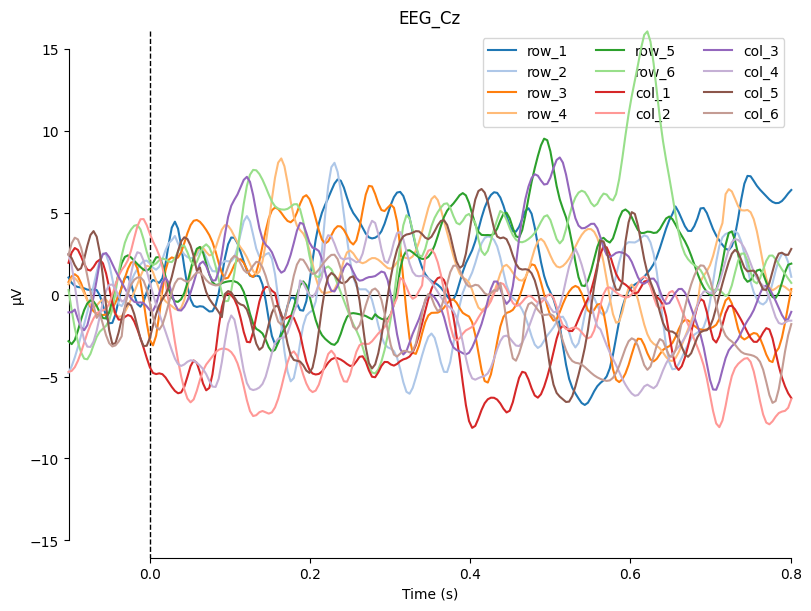

[<Figure size 800x600 with 1 Axes>]

In [ ]:
evokeds = {cond: epochs[cond].average() for cond in epochs.event_id.keys()}

import matplotlib.pyplot as plt

# 20 colores disponibles, más que suficiente para 12 condiciones
base_colors = plt.cm.tab20.colors  

evokeds = {cond: epochs[cond].average() for cond in epochs.event_id.keys()}

colors = {cond: base_colors[i] for i, cond in enumerate(evokeds.keys())}

mne.viz.plot_compare_evokeds( evokeds, picks="EEG_Cz", colors=colors, legend='upper right' )




## PASO 3: Calcular la amplitud del P300 entre 300–600 ms

In [ ]:
import numpy as np

p300_window = (0.3, 0.6)

p300_amplitudes = {}
for cond, evk in evokeds.items():
    data = evk.copy().pick("EEG_Pz").data[0]
    times = evk.times
    idx = np.where((times >= p300_window[0]) & (times <= p300_window[1]))[0]
    p300_amplitudes[cond] = data[idx].mean()

p300_amplitudes


{'row_1': np.float64(-7.781439794773129e-07),
 'row_2': np.float64(1.163684784351451e-06),
 'row_3': np.float64(4.6581060606060615e-07),
 'row_4': np.float64(3.9822955266955284e-06),
 'row_5': np.float64(2.3360323873657205e-06),
 'row_6': np.float64(3.674774891774891e-06),
 'col_1': np.float64(-3.289580567580566e-06),
 'col_2': np.float64(-2.272765079365079e-06),
 'col_3': np.float64(1.9716318742985403e-06),
 'col_4': np.float64(-7.531872294372298e-07),
 'col_5': np.float64(-4.368664421997752e-07),
 'col_6': np.float64(-1.3735810048537321e-06)}

## PASO 4: Elegir la fila y columna con mayor P300 → letra seleccionada

In [ ]:
rows = {k:v for k,v in p300_amplitudes.items() if "row" in k}
cols = {k:v for k,v in p300_amplitudes.items() if "col" in k}

row_selected = max(rows, key=rows.get)
col_selected = max(cols, key=cols.get)

row_selected, col_selected


('row_4', 'col_3')

In [ ]:
### BUSCANDO LETRA EN MATRIZ
matrix = [
    ["A","B","C","D","E","F"],
    ["G","H","I","J","K","L"],
    ["M","N","O","P","Q","R"],
    ["S","T","U","V","W","X"],
    ["Y","Z","1","2","3","4"],
    ["5","6","7","8","9","0"],
]

print(letra(row_selected, col_selected))


U


# Viendo info del database

In [ ]:
events = mne.find_events(raw, stim_channel="StimulusCode")
print(events[:20])


Finding events on: StimulusCode
109 events found on stim channel StimulusCode
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
[[1152    0   11]
 [1184    0    4]
 [1216    0    6]
 [1248    0    3]
 [1280    0   12]
 [1312    0    2]
 [1344    0    9]
 [1376    0    1]
 [1408    0    7]
 [1440    0    8]
 [1472    0   10]
 [1504    0    5]
 [1536    0    2]
 [1568    0    8]
 [1600    0    9]
 [1632    0   12]
 [1664    0    4]
 [2592    0   10]
 [2624    0    1]
 [2656    0    3]]


En la sgte grafica, la señal digital que marca cuándo cada fila o columna fue iluminada.

Ese canal es un trigger y cada vez que una fila/columna parpadea → el canal pone un número (1–12)

Cuando no pasa nada → el canal está en 0

Por eso se veía como una señal de escalones (sube y baja), no como ondas EEG

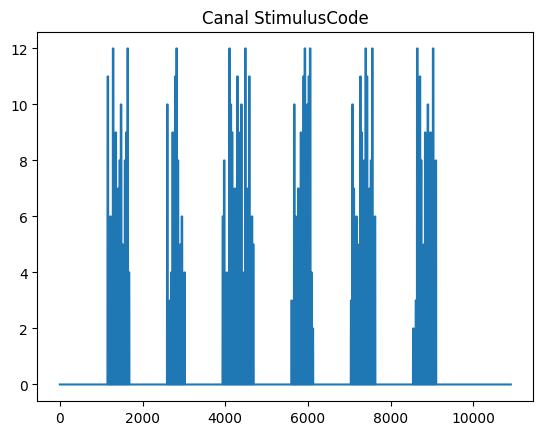

In [ ]:
import matplotlib.pyplot as plt

stim = raw.get_data(picks="StimulusCode")[0]
plt.plot(stim)
plt.title("Canal StimulusCode")
plt.show()


## Viendo eventos [donde ocurrió el estímulo- canal (siempre 0 en MNE para eventos) - #row/colum]

In [ ]:
events = mne.find_events(raw, stim_channel="StimulusCode", shortest_event=1)
print(events[:40])


Finding events on: StimulusCode
109 events found on stim channel StimulusCode
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
[[1152    0   11]
 [1184    0    4]
 [1216    0    6]
 [1248    0    3]
 [1280    0   12]
 [1312    0    2]
 [1344    0    9]
 [1376    0    1]
 [1408    0    7]
 [1440    0    8]
 [1472    0   10]
 [1504    0    5]
 [1536    0    2]
 [1568    0    8]
 [1600    0    9]
 [1632    0   12]
 [1664    0    4]
 [2592    0   10]
 [2624    0    1]
 [2656    0    3]
 [2688    0    4]
 [2720    0    9]
 [2752    0    7]
 [2784    0   11]
 [2816    0   12]
 [2848    0    8]
 [2880    0    2]
 [2912    0    5]
 [2944    0    6]
 [2976    0    1]
 [3008    0    4]
 [3936    0    6]
 [3968    0    8]
 [4000    0    3]
 [4032    0    4]
 [4064    0    2]
 [4096    0   12]
 [4128    0   10]
 [4160    0    9]
 [4192    0    1]]


## Nombres de canles

In [ ]:
print(raw.ch_names)


['EEG_F3', 'EEG_Fz', 'EEG_F4', 'EEG_T7', 'EEG_C3', 'EEG_Cz', 'EEG_C4', 'EEG_T8', 'EEG_CP3', 'EEG_CP4', 'EEG_P3', 'EEG_Pz', 'EEG_P4', 'EEG_PO7', 'EEG_PO8', 'EEG_Oz', 'A_1_1', 'B_1_2', 'C_1_3', 'D_1_4', 'E_1_5', 'F_1_6', 'G_2_1', 'H_2_2', 'I_2_3', 'J_2_4', 'K_2_5', 'L_2_6', 'M_3_1', 'N_3_2', 'O_3_3', 'P_3_4', 'Q_3_5', 'R_3_6', 'S_4_1', 'T_4_2', 'U_4_3', 'V_4_4', 'W_4_5', 'X_4_6', 'Y_5_1', 'Z_5_2', 'Sp_5_3', '1_5_4', '2_5_5', '3_5_6', '4_6_1', '5_6_2', '6_6_3', '7_6_4', '8_6_5', '9_6_6', 'StimulusType', 'SelectedTarget', 'SelectedRow', 'SelectedColumn', 'PhaseInSequence', 'StimulusBegin', 'StimulusCode', 'CurrentTarget', 'FakeFeedback', 'DisplayResults']
